In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
train_data = pd.read_csv('data/intermediate_data/train_processed.csv')
test_data = pd.read_csv('data/intermediate_data/test_processed.csv')
train_processed = list(train_data.text.values)
train_labels = list(train_data.sentiment.values)
test_processed = list(test_data.text.values)
test_labels = list(test_data.sentiment.values)

## Read pre-trained embeddings

In [3]:
file = 'data/glove.6B.100d.txt'
word_emb = {}
with open(file) as fi:
    for line in fi:
        items = line.split()
        word_emb[items[0]] = np.array(items[1:], dtype=np.float32)

In [4]:
#Vocabulary size
len(word_emb.keys())

400000

In [5]:
def word2vec(word, vocab_embed):
    try:
        vec = vocab_embed[word]
    except:
        vec = word_emb['unk']
    return vec

## Represent each sentence as the average embeddings of words

In [14]:
#Computer the sent vector based on word vectors
emb_size = 100
train_sent_vecs = []
for sent in train_processed:
    words = sent.split()
    sent_vec = np.zeros(emb_size)*1.0
    for word in words:
        vec = word2vec(word, word_emb)
        sent_vec += vec
    train_sent_vecs.append(sent_vec/len(words))

In [7]:
test_sent_vecs = []
for sent in test_processed:
    words = sent.split()
    sent_vec = np.zeros(emb_size)*1.0
    for word in words:
        vec = word2vec(word, word_emb)
        sent_vec += vec
    test_sent_vecs.append(sent_vec/len(words))

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
model = LogisticRegression()
model.fit(train_sent_vecs, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [9]:
model.score(train_sent_vecs, train_labels)

0.80124

In [10]:
model.score(test_sent_vecs, test_labels)

0.79632

## Visualize Word Embeddings

In [10]:
words = word_emb.keys()

In [11]:
words = list(words)
words = ['good', 'bad', 'nice', 'awesome', 'fuck', 'shit', 'positive']
embs = []
for w in words:
    embs.append(word_emb[w])
embs = np.stack(embs)

In [183]:
from sklearn.manifold import TSNE
num_points = 400
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(embs)

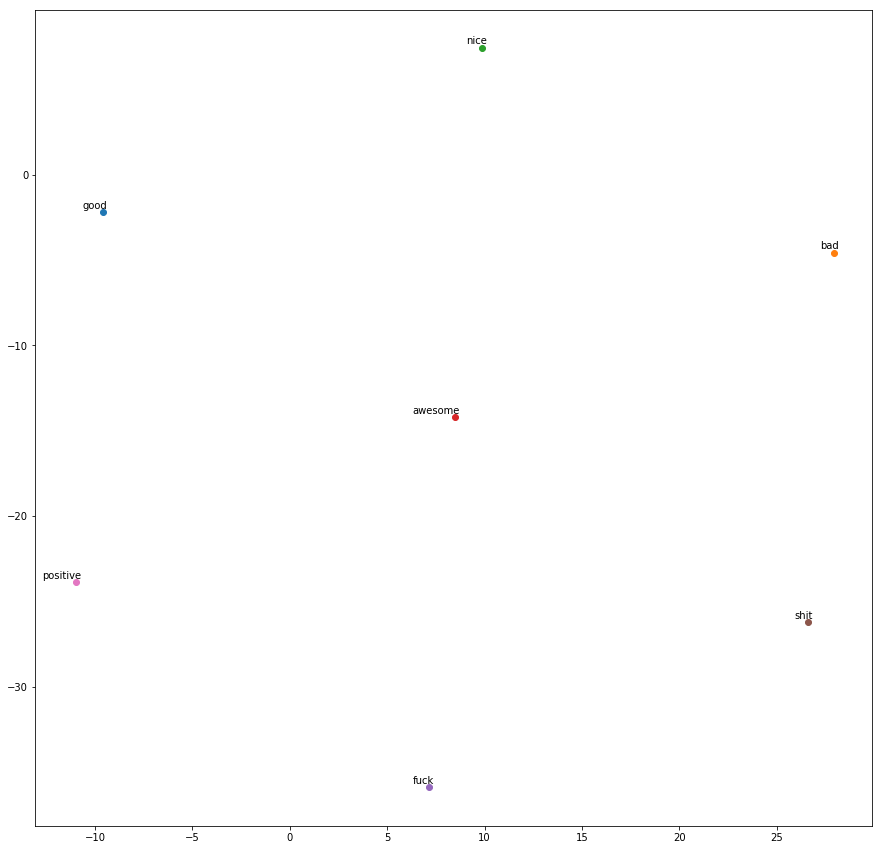

In [184]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')

#words = [list(ti.get_vocab())[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

## CNN

In [6]:
sent_lengths = [len(sent.split()) for sent in train_processed]

In [7]:
np.percentile(sent_lengths, [0, 25, 50, 75, 90])

array([ 10., 129., 177., 288., 464.])

In [9]:
#Computer the sent vector based on word vectors
max_word_len = 800
emb_size = 100

In [10]:
class generate_samples:
    '''
    Generate samples for training data or testing data
    '''
    def __init__(self, data, labels, is_training=True):
        '''
        Args:
        data: numpy
        labels: numpy
        '''
        self.data = data
        self.labels = labels
        self.is_training = is_training
        self.index = 0
        
    def generate_samples(self, sents, labels, batch_size=64):
        '''
        Select a batch_size of sentences
        Transform each sentence into a sequence of embeddings
        '''
        indice = np.random.choice(len(sents), batch_size)
        sents = sents[indice]
        labels = labels[indice]
        sent_vecs, sent_lens = self.create_sent_emb(sents)
        return sent_vecs, labels, sent_lens
    
    def create_sent_emb(self, sents):
        '''
        Create sequences of word embeddings for sentences
        '''
        sent_vecs = []#A matrix represents a sentence
        sent_lens = []#length of each sentence
        for sent in sents:
            words = sent.split()
            sent_lens.append(len(words))
            sent_vec = []
            for word in words:
                vec = word2vec(word, word_emb)
                sent_vec.append(vec)
            #Cut long sentence
            if len(words) > max_word_len:
                sent_vec = sent_vec[:max_word_len]
            #Pad short sentence
            if len(words) < max_word_len:
                for _ in np.arange(max_word_len - len(words)):
                    vec = np.zeros(emb_size)
                    sent_vec.append(vec)
            sent_vec = np.stack(sent_vec)
            sent_vecs.append(sent_vec)
        sent_vecs = np.stack(sent_vecs)
        return sent_vecs, sent_lens
        
    def generate(self, batch_size=64):
        if self.is_training:
            sent_vecs, sent_labels, lengths = self.generate_samples(self.data, 
                                                               self.labels,
                                                              batch_size)
        else:
            start = self.index
            end = start + batch_size
            if end > len(self.data):
                print('Out of sample size')
                self.index = 0
            sents = self.data[start:end]
            sent_labels = self.labels[start:end]
            sent_vecs, lengths = self.create_sent_emb(sents)
            self.index = end
        return sent_vecs, sent_labels, lengths
            
            

In [11]:
train_gs = generate_samples(np.array(train_processed), np.array(train_labels))

In [12]:
sent_vecs, sent_labels, lengths = train_gs.generate(8)

In [13]:
test_gs = generate_samples(np.array(test_processed), np.array(test_labels), False)

In [14]:
sent_vecs, sent_labels, lengths = test_gs.generate(8)

## CNN

In [15]:
from models.CNN_Pretrained_Embedding import CNN_Model_Pretrained_Emb

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [16]:
class trainConfig:
    max_doc_len = max_word_len
    label_size = 2
    embed_size = 100
    hidden_size = 250
    batch_size = 64
    layer_size = 2
    
class testConfig:
    max_doc_len = max_word_len
    label_size = 2
    embed_size = 100
    hidden_size = 250
    batch_size = 64
    layer_size = 2
    
class singleConfig:
    max_doc_len = max_word_len
    label_size = 2
    embed_size = 100
    hidden_size = 250#hidden size for hidden state of rnn
    batch_size = 1
    layer_size = 2

In [17]:
import tensorflow as tf
graph_cnn = tf.Graph()
#Create models for training and testing data
with graph_cnn.as_default():
    initializer = tf.random_uniform_initializer(-0.02, 0.02)
    with tf.name_scope('train'):
        #Set different models for different buckets
        with tf.variable_scope("Model", reuse=None, initializer=initializer):
            train_model = CNN_Model_Pretrained_Emb(trainConfig)
            saver=tf.train.Saver()
    with tf.name_scope('test'):
        #Set different models for different buckets
        with tf.variable_scope("Model", reuse=True, initializer=initializer):
            test_model = CNN_Model_Pretrained_Emb(testConfig, False)
            single_model = CNN_Model_Pretrained_Emb(singleConfig, False)

Model Initialized!
Model Initialized!
Model Initialized!


In [18]:
train_chunk_num = int(len(train_processed)/trainConfig.batch_size)
test_chunk_num = int(len(test_processed)/testConfig.batch_size)
train_chunk_num

390

In [19]:
remain_num = len(test_processed) - test_chunk_num * testConfig.batch_size
remain_num

40

In [ ]:
import time, os
epochs = 2
#train_chunk_num = 10
file = "ckpt_cnn_pretrained_emb/cnn.ckpt"
with tf.Session(graph=graph_cnn) as sess:
    #Initialize parameters
    init = tf.global_variables_initializer()
    if not os.path.exists("ckpt_cnn_pretrained_emb"):
        os.mkdir('ckpt_cnn_pretrained_emb')
    if os.path.exists("ckpt_cnn_pretrained_emb/cnn.ckpt.index"):
        saver.restore(sess, file)
    else:
        sess.run(init)
    start_time = time.time()
    for m in range(epochs):
        for i in range(train_chunk_num):
            #sess.run(tf.assign(learning_rate, 0.002*((0.98)**m)))
            x, y, lengths = train_gs.generate(trainConfig.batch_size)
            feed_dict = {train_model.x:x, train_model.y:y, train_model.lengths:lengths}
            l, _ = sess.run([train_model.cost, train_model.optimize], feed_dict=feed_dict)
            if i%100 == 0:
                print('Loss:', round(l, 4))
        end_time = time.time()
        print('Epoch', m, 'time:{:.2f}'.format(end_time - start_time))
        
    saver.save(sess,'ckpt_cnn_pretrained_emb/cnn.ckpt')
     

INFO:tensorflow:Restoring parameters from ckpt_cnn_pretrained_emb/cnn.ckpt
Loss: 0.5197
Loss: 0.5306


In [ ]:
#Calculate Testing Accuracy
with tf.Session(graph=graph_cnn) as sess:
    print('Testing...')
    count = 0
    #saver = tf.train.import_meta_graph('ckpt_cnn/cnn.ckpt.meta')
    saver.restore(sess,tf.train.latest_checkpoint('ckpt_cnn_pretrained_emb/'))
    print('Parameters restored')
    start_time = time.time()
    test_gs = generate_samples(np.array(test_processed), np.array(test_labels), False)
    for _ in range(test_chunk_num):
        #Traverse each data
        x, y, lengths = test_gs.generate(testConfig.batch_size)
        feed_dict = {test_model.x:x, test_model.y:y, test_model.lengths:lengths}
        n = sess.run(test_model.correct_num, feed_dict=feed_dict)
        count += np.sum(n)
    for _ in range(remain_num):
        #Traverse each data
        x, y, lengths = test_gs.generate(1)
        feed_dict = {single_model.x:x, single_model.y:y, 
                     single_model.lengths:lengths}
        n = sess.run(single_model.correct_num, feed_dict=feed_dict)
        count += np.sum(n)
    end_time = time.time()
    print('Testing Time:{:.2f}'.format(end_time - start_time))
    print(count*1.0/len(test_processed)) 

The result of CNN based on pretrained-Glove word embeddings i 0.83876.